In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
# from sklearn import datasets, dummy, linear_model, metrics
import sklearn.linear_model as lm
from sklearn import dummy, metrics

#import itertools
#import pandas_datareader.data as pdweb
#from pandas_datareader.data import DataReader
#from datetime import datetime
#from io import StringIO

In [2]:
raw_df = pd.read_csv('../data/framingham.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
male               4240 non-null int64
age                4240 non-null int64
education          4135 non-null float64
currentSmoker      4240 non-null int64
cigsPerDay         4211 non-null float64
BPMeds             4187 non-null float64
prevalentStroke    4240 non-null int64
prevalentHyp       4240 non-null int64
diabetes           4240 non-null int64
totChol            4190 non-null float64
sysBP              4240 non-null float64
diaBP              4240 non-null float64
BMI                4221 non-null float64
heartRate          4239 non-null float64
glucose            3852 non-null float64
TenYearCHD         4240 non-null int64
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [3]:
raw_df.dropna(inplace=True)
print('naive prediction accuracy is {:4f}'.format(len(raw_df[raw_df['TenYearCHD']==0])/len(raw_df)))
pd.crosstab(raw_df['TenYearCHD'], raw_df['TenYearCHD'].count(), colnames=['Row_Count'])

naive prediction accuracy is 0.847731


Row_Count,3658
TenYearCHD,
0,3101
1,557


In [4]:
# Now let's split our data into train & test, set seed to 1000
# sample.split in R

train, test = train_test_split(raw_df, test_size=0.35, random_state=1000)
print('train has:',len(train),'\ntest has:',len(test))

train has: 2377 
test has: 1281


In [5]:
train.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [6]:
framinghamLog = smf.GLM.from_formula(formula='TenYearCHD ~ male+age+education+currentSmoker+cigsPerDay+ \
BPMeds+prevalentStroke+prevalentHyp+diabetes+totChol+sysBP+diaBP+BMI+heartRate+glucose', data=train, family=sm.families.Binomial()).fit()
framinghamLog.summary()

# model = lm.LogisticRegression()
# model.fit(train[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
#        'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
#        'diaBP', 'BMI', 'heartRate', 'glucose']],train['TenYearCHD'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 2377
Model:                            GLM   Df Residuals:                     2361
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -870.77
Date:                Fri, 29 Jul 2016   Deviance:                       1741.5
Time:                        16:11:46   Pearson chi2:                 2.40e+03
No. Iterations:                     8                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -9.8803      0.933    -10.592      0.000       -11.709    -8.052
male                0.7192      0.138      5.201      0.000         0.448     0.990
age                 0.0734      0.008      8.648      0.000         0.057     0.090
education          -0.0186      0.061     -0.304      0.761        -0.138     0.101
currentSmoker      -0.0119      0.199     -0.060      0.952        -0.402     0.378
cigsPerDay          0.0160      0.008      2.025      0.043         0.001     0.032
BPMeds              0.2245      0.293      0.767      0.443        -0.349     0.798
prevalentStroke     1.1207      0.528      2.123      0.034         0.086     2.155
prevalentHyp        0.0755      0.174      0.434      0.664        -0.265     0.416
diabetes           -0.1202      0.416     -0.289      0.773        -0.937     0.696
totChol             0.0036      0.001      2.575      0.010         0.001     0.006
sysBP               0.0148      0.005      3.044      0.002         0.005     0.024
diaBP              -0.0044      0.008     -0.527      0.598        -0.021     0.012
BMI                 0.0138      0.016      0.850      0.396        -0.018     0.046
heartRate           0.0033      0.005      0.640      0.522        -0.007     0.014
glucose             0.0082      0.003      2.818      0.005         0.002     0.014
===================================================================================
"""

In [7]:
predictTest = framinghamLog.predict(test)
print('min: ',predictTest.min())
print('mean: ',predictTest.mean())
print('median: ',np.median(predictTest))
print('max: ',predictTest.max())

min:  0.0111892680795
mean:  0.147342015964
median:  0.110215567075
max:  0.93840758005


In [8]:
# Now make a confusion matrix

# (1) merge prediction results with test actual data
ConfuMatrix_df = pd.DataFrame(predictTest, columns=['My_Pred_Proba'])
temp2 = pd.DataFrame(test['TenYearCHD'].tolist(), columns=['Actual'])
ConfuMatrix_df = ConfuMatrix_df.join(temp2)
del temp2

# (2) set threshold and translate proba into classes
threshold = 0.5
ConfuMatrix_df['Pred_TF']=ConfuMatrix_df['My_Pred_Proba']>threshold
del threshold

# (3) draw the confusion matrix
pd.crosstab(ConfuMatrix_df['Actual'],ConfuMatrix_df['Pred_TF'])
# pd.pivot_table(ConfuMatrix_df,index='Actual',columns='Pred_TF',aggfunc='count')

Pred_TF,False,True
Actual,,
0,1069,10
1,191,11


In [9]:
print("***OWEN'S CONFUSION SUMMARY***\n")

TP = np.sum(ConfuMatrix_df[ConfuMatrix_df['Actual']==1]['Pred_TF'])
print('# True Positive: {}'.format(TP))
FP = np.sum(ConfuMatrix_df[ConfuMatrix_df['Actual']==0]['Pred_TF'])
print('# False Positive: {}'.format(FP))
TN = len(ConfuMatrix_df[ConfuMatrix_df['Actual']==0]) - np.sum(ConfuMatrix_df[ConfuMatrix_df['Actual']==1]['Pred_TF'])
print('# True Negative: {}'.format(TN))
FN = len(ConfuMatrix_df[ConfuMatrix_df['Actual']==1]) - np.sum(ConfuMatrix_df[ConfuMatrix_df['Actual']==1]['Pred_TF'])
print('# False Negative: {}'.format(FN))
Accuracy = ((TP+TN)/(TP+TN+FP+FN))
print('Accuracy: {}'.format(Accuracy))
naive = max(len(ConfuMatrix_df[ConfuMatrix_df['Actual']==0]),len(ConfuMatrix_df[ConfuMatrix_df['Actual']==1]))/len(ConfuMatrix_df)
print('Naive Baseline Method: {}'.format(naive))
Sensitivity = (TP/(TP+FN))
print('Sensitivity/Recall: {}'.format(Sensitivity))
Specificity = (TN/(TN+FP))
print('Specificity: {}'.format(Specificity))
Precision = (TP/(TP+FP))
print('Precision: {}'.format(Precision))
Fmeasure = 2/((1/Precision)+(1/Sensitivity))
print('F-Measure: {}'.format(Fmeasure))

***OWEN'S CONFUSION SUMMARY***

# True Positive: 11
# False Positive: 10
# True Negative: 1068
# False Negative: 191
Accuracy: 0.84296875
Naive Baseline Method: 0.8423106947697112
Sensitivity/Recall: 0.054455445544554455
Specificity: 0.9907235621521335
Precision: 0.5238095238095238
F-Measure: 0.09865470852017937


## NOW GET FANCY AND DO FANCY STUFF

In [10]:
model0 = dummy.DummyClassifier()
model0.fit(train[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']], train['TenYearCHD'])

train['probability_0'] = model0.predict_proba(train[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']]).T[1]
test['probability_0'] = model0.predict_proba(test[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']]).T[1]


model1 = lm.LogisticRegression()
model1.fit(train[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']], train['TenYearCHD'])

train['probability_1'] = model1.predict_proba(train[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']]).T[1]
test['probability_1'] = model1.predict_proba(test.loc[:,['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']]).T[1]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\

In [11]:
train.shape

(2377, 18)

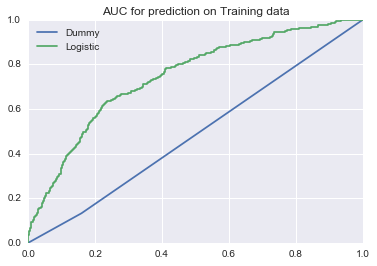

In [12]:
ax = plt.subplot(111)
vals = metrics.roc_curve(train.TenYearCHD, train.probability_0)
ax.plot(vals[0], vals[1], label='Dummy')

vals = metrics.roc_curve(train.TenYearCHD, train.probability_1)
ax.plot(vals[0], vals[1], label='Logistic')

ax.set(title='AUC for prediction on Training data', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))
ax.legend(loc='upper left', shadow=True);

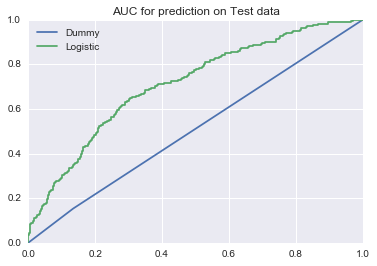

In [13]:
ax = plt.subplot(111)
vals = metrics.roc_curve(test.TenYearCHD, test.probability_0)
ax.plot(vals[0], vals[1], label='Dummy')

vals = metrics.roc_curve(test.TenYearCHD, test.probability_1)
ax.plot(vals[0], vals[1], label='Logistic')

ax.set(title='AUC for prediction on Test data', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))
ax.legend(loc='upper left', shadow=True);

In [14]:
y_true = train.TenYearCHD
y_preds = train.probability_1

metrics_summary = {}
for threshold in np.arange(0, 1, 0.05):
    print(threshold)
    y_preds = train.probability_1.apply(lambda x: 0 if x <= threshold else 1)
    metrics_summary[metrics.recall_score(y_true=y_true,y_pred=y_preds)] = \
    metrics.precision_score(y_true=y_true, y_pred=y_preds)
    
print(pd.Series(metrics_summary).to_frame().reset_index())

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
       index         0
0   0.000000  0.000000
1   0.002817  0.500000
2   0.014085  0.833333
3   0.025352  0.900000
4   0.039437  0.823529
5   0.064789  0.676471
6   0.078873  0.636364
7   0.118310  0.494118
8   0.169014  0.410959
9   0.247887  0.384279
10  0.391549  0.371658
11  0.549296  0.333904
12  0.698592  0.263549
13  0.856338  0.213783
14  0.974648  0.164449
15  1.000000  0.149348


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
metrics.roc_auc_score(train.TenYearCHD, train.probability_1)

0.74505231189311949

In [16]:
metrics.roc_auc_score(test.TenYearCHD, test.probability_1)

0.71139393828168718

In [17]:
# metrics.recall_score(train.TenYearCHD, train.probability_1)


1